
1.  Data importation: extract all agent utterances of conversations that have “taxi” as only goal (taxi booking service)

In [1]:
import json
import os 
import pandas as pd 
# obtain path to the script 
dir_path = os.path.dirname("__file__")

data_path=os.path.join(dir_path, "data.json") # expects that the data file is stored in the current directory
f=open(data_path)
data=json.load(f)

In [2]:
"""
identifies instances in json documents where only 'train' occurs
"""

# each key refers to conversation of X exchanges
# extract the conversation goals 
conversation_list=[] # a list to hold the list of all exchanges per conversation 
for key in data.keys(): # for each conversation 
    conversation_goals_list=[] # for each conversation keep all exchanges 
    for item in data[key]["goal"]:
        if item != "message" and item != "topic": # ignore topic and message 
            # loop through and grab all populated conversation goals 
            if len(data[key]["goal"][item].keys()) > 0: # skip empty goals 
                conversation_goals_list.append(item)
    conversation_list.append(conversation_goals_list) # list of convo_goals per conversation 
        
        
# populate a df with unique conversation id, and a list of respective goals 
df_convo=pd.DataFrame({"convo_id" : list(data.keys()), "convo_goals": conversation_list})
#print(df_convo.shape)

# method to determine if taxi features as a goal 
def detect_target_values(row):
    # first see if train is present 
    if "train" in row:
        # excluding all multiple-topic conversations 
        if len(row) == 1:
            return 1
    return 0
# identifies all instances of train and further filters all non singleton instances of 'train' conversations
df_convo["train"] = df_convo["convo_goals"].apply(detect_target_values) 
# create a sub df with only train based topics. 
df_train=df_convo[df_convo.train == 1]
print("There are {} conversations that feature 'train' only".format(df_train.shape[0]))

# having identified are target conversations, we iterate through the data and pull out the info related to our keys
train_dict = {key: value for key, value in data.items() if key in list(df_train.convo_id)}

# drill into the 'logs' and extract : text || dialog_act || turn_id
text_list=[]
dialog_list=[] 
turn_id_list=[]
id_list=[]
for k,v in train_dict.items():
    for value in v['log']:
        text_list.append(value['text'])
        dialog_list.append(value['dialog_act'].keys())
        turn_id_list.append(value['turn_id'])
        id_list.append(k) # retain conversation reference 
        
# populate a dataframe with our targeted data 
df_utterances=pd.DataFrame({"ids": id_list, "turns":turn_id_list, "dialog_intent": dialog_list, "text": text_list })
print(df_utterances.shape)

# only retain conversations related to the agent, i.e modulus 2
df_agent_utterances=df_utterances[df_utterances.turns % 2==1]
print(df_agent_utterances.shape)



There are 345 conversations that feature 'train' only
(3542, 4)
(1771, 4)


In [3]:
print(df_utterances.head())


            ids  turns                  dialog_intent  \
0  SNG0297.json      0                 (Train-Inform)   
1  SNG0297.json      1                (Train-Request)   
2  SNG0297.json      2                 (Train-Inform)   
3  SNG0297.json      3  (Train-Inform, Train-Request)   
4  SNG0297.json      4  (Train-Inform, Train-Request)   

                                                text  
0  I am looking for a train departing from london...  
1  I 'll be glad to help . You would like to from...  
2  Cambridge . I 'd like to leave after 10:00 on ...  
3  I have seven trains , could you tell me when y...  
4  Just any time after 10:00 , can I get the trai...  


2. Preprocessing: perform any preprocessing/utterance encoding you may deem necessary for the tasks below

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import string 
import re
from sklearn.cluster import KMeans

from nltk.corpus import stopwords
import matplotlib.pyplot as plt
# run below if having trouble with accessing stopwords
# need only be run once. 
#nltk.download('stopwords')
stop = set(stopwords.words("english"))


class PreProcessText:
    """ class that performs tfidf on text"""
    def __init__(self, df):
        """ init accepts the dataframe, adds the text col and processes the tfidf"""
        self.all_rows=[]
        self.df = df
        # initialise vectoriser, limit terms to ones that have a % frequency  x > 1 and x < 90
        self.vectoriser=TfidfVectorizer(min_df=0.01, max_df=0.90)
        # vectorise the text 
        self.df['body_text'] = self.df.text.apply(self.create_vsm)
        
        
    def create_vsm(self, convo):
        # mask some generic symbols 
        convo=re.sub("\d+:\d+", "time_stamp", convo) # substitute time ref for a generic stamp: 10:10 -> time_Stamp
        convo= re.sub("\d+\.\d+", "money_ref", convo) # sub money ref for generic stamp: 12.50 -> money_ref
        convo=re.sub("[A-Z]{1,}\d+", "ref_num", convo)# sub train ref for generic stamp: TR900 -> ref_num
        
        # remove punctuation 
        removeSyms = string.punctuation 
        # include underscore for above masks 
        removeSyms = removeSyms.replace("_", "")
        pattern=r"[{}]".format(removeSyms)
        # apply the pattern to the string, remove space, lowercase 
        convo = re.sub(pattern, " ", convo.strip().lower())
        
        # finally, tokenize and exclude stopwords 
        sent=[word for word in convo.split() if word not in stop]
        return " ".join(sent) 
        
    
    def vectorise(self):
        """method runs tfidf vectoriser"""
        text = self.df.body_text.values
        X = self.vectoriser.fit_transform(text)
        return X

4. Utterance classification: train and evaluate a supervised utterance classifier that recognizes utterances of these 5 most common utterance types. How well is the classifier working on unseen utterances of known types? Could you use this classifier to realize a utterance does not belong to any known type, yet properly classify utterances of known types? How?

/var/folders/9t/cmsf896j78b50t605vx52k640000gn/T/ipykernel_998/639051618.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['body_text'] = self.df.text.apply(self.create_vsm)


 Fit 2 clusters
 Fit 3 clusters
 Fit 4 clusters
 Fit 5 clusters
 Fit 6 clusters
 Fit 7 clusters
 Fit 8 clusters
 Fit 9 clusters
 Fit 10 clusters
 Fit 11 clusters
 Fit 12 clusters
 Fit 13 clusters
 Fit 14 clusters
 Fit 15 clusters
 Fit 16 clusters
 Fit 17 clusters
 Fit 18 clusters
 Fit 19 clusters
 Fit 20 clusters


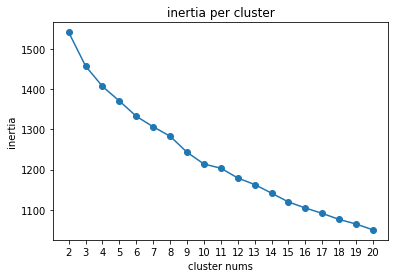

In [5]:
text_processor=PreProcessText(df_agent_utterances)

def find_optimal_num_clusters(data, max_k):
    """ method takes data and target num_clusters and determines optimal number of clusters"""
    iters=range(2,max_k + 1, 1) # set iteration number 
    inertia_values=[]
    
    for k in iters:
        inertia_values.append(KMeans(n_clusters=k, init='k-means++', 
                                random_state=10).fit(data).inertia_)
        print(' Fit {} clusters'.format(k))
        
    (f, ax) = plt.subplots(1,1)
    ax.plot(iters, inertia_values, marker="o")
    ax.set_xlabel("cluster nums")
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel("inertia")
    ax.set_title("inertia per cluster")
    plt.show()

X=text_processor.vectorise()
find_optimal_num_clusters(X, 20)
# optimal number of clusters == 10

running the above cell would suggest that the ideal number of clusters would be 10 
Further work could focus on drilling into the differences of the clusters, though the suspicion is that there is not enough input data to generate distinct rich clusters. I.E much of the input text is very similar. 
Proceeding with the assignment brief it was elected to only focus on 5 sub topics. 

In [8]:
import pprint as pp
import numpy as np
def get_cluster_themes(data,clusters,labels,n_terms):
    """ method determines the theme of each cluster"""
    themes_dict={}
    df=pd.DataFrame(data.todense()).groupby(clusters).mean() # creates a row for each cluster and a column per term 
    for (i,r) in df.iterrows():
        themes_dict[i] = " , ".join(labels[t] for t in np.argsort(r)[-n_terms:]) # join the weights table that correspod to the top n terms in the cluser row 
    return themes_dict

n5_clusters=KMeans(n_clusters=5, init="k-means++", random_state=10)
y_pred=n5_clusters.fit_predict(X.toarray())
text_processor.df['y'] = y_pred
themes_dict=get_cluster_themes(X, y_pred, text_processor.vectoriser.get_feature_names(), 10)
print(pp.pprint(themes_dict))

{0: 'else , trip , anything , need , departing , goodbye , help , thank , '
    'destination , welcome',
 1: 'depart , minutes , day , arrive , trains , travel , leave , would , like '
    ', time',
 2: 'fee , anything , payable , money_ref , else , booked , station , gbp , '
    'number , reference',
 3: 'towninfo , centre , wonderful , traveling , good , thank , nice , welcome '
    ', great , day',
 4: 'work , like , cambridge , book , would , arrives , leaves , train , '
    'ref_num , time_stamp'}
None


/var/folders/9t/cmsf896j78b50t605vx52k640000gn/T/ipykernel_998/2900760060.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_processor.df['y'] = y_pred


Having run the above cell one could select 5 labels for the documents as follows:
1. saluations-leaving
2. train-departure_needs-request
3. money-request
4. arrival-instructions
5. booking-depart-instructions

Alternatively one could apply LDA to the model 

In [107]:
import gensim 
from gensim import corpora
from gensim import models 
import numpy as np
from gensim.corpora import Dictionary
from gensim.models import LdaModel


# take the processed doc and return to vector to suit gensim input type
tokenised_text = [doc.split() for doc in text_processor.df.body_text.values]

# cast to a dictionary 
dictionary=Dictionary(tokenised_text)
corpus = [dictionary.doc2bow(doc) for doc in tokenised_text]
#print(len(corpus))

# to load the dictionary 
temp=dictionary[0]

id2word=dictionary.id2token
model=LdaModel(corpus=corpus,
                id2word=id2word,
                  alpha="auto",
                  eta="auto",
              iterations=400, 
              num_topics=5,
              passes=20)

In [141]:
#print(model.show_topics())
for i, r in iter(model.show_topics()):
    print(re.sub(r'[^a-z ]+', '', r))
    print()


timestamp  refnum  would  train  like  cambridge  book  leaves  arrives  leaving

time  trains  day  like  leave  would  arrive  travel  need  available

pounds  moneyref  help  destination  could  departing  minutes  glad  price  departure

number  reference  else  anything  moneyref  gbp  station  help  booked  payable

day  welcome  thank  great  trip  goodbye  using  cambridge  centre  nice



LDA topics seem to produce less cohesive topic types, loosely speaking one could argue that themes are 
1. specific-train-time-request
2. general-train-time-request
3. payment-request
4. end-of-transaction
5. saluations-bye

5. Utterance classification: train and evaluate a supervised utterance classifier that recognizes utterances of these 5 most common utterance types. How well is the classifier working on unseen utterances of known types? Could you use this classifier to realize a utterance does not belong to any known type, yet properly classify utterances of known types? How?

In [142]:
print(text_processor.df.head())


             ids  turns                  dialog_intent  \
1   SNG0297.json      1                (Train-Request)   
3   SNG0297.json      3  (Train-Inform, Train-Request)   
5   SNG0297.json      5                 (Train-Inform)   
7   SNG0297.json      7                  (general-bye)   
9  SNG01450.json      1                (Train-Request)   

                                                text  \
1  I 'll be glad to help . You would like to from...   
3  I have seven trains , could you tell me when y...   
5                             TR7943 leaves at 11:39   
7                                 Have a great day !   
9      What time and day are you looking to travel ?   

                                           body_text  y  
1  glad help would like london liverpool street d...  0  
3          seven trains could tell would like arrive  1  
5                          ref_num leaves time_stamp  4  
7                                          great day  3  
9                       

In [9]:
def cluster_convert(row):
    ''' method iterates over y (the cluster value assigned the doc) 
    and converts it to a text label which we manually determined'''
    
    intents = ["saluations-leaving","train-departure_needs-request", "money-request", 
                               "arrival-instructions", "booking-depart-instructions"]
    return intents[row]


text_processor.df['term_intent'] = text_processor.df.y.apply(cluster_convert)
#print(text_processor.df.head())
print(text_processor.df.term_intent.value_counts())

saluations-leaving               577
booking-depart-instructions      427
train-departure_needs-request    325
arrival-instructions             228
money-request                    214
Name: term_intent, dtype: int64


/var/folders/9t/cmsf896j78b50t605vx52k640000gn/T/ipykernel_998/150045704.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_processor.df['term_intent'] = text_processor.df.y.apply(cluster_convert)


In [10]:
# create a test/train split in our data
print(text_processor.df.columns)
from sklearn.model_selection import train_test_split 
train, test = train_test_split(text_processor.df, test_size=0.2)

train_data=train.body_text
train_labels=train.term_intent

test_data=test.body_text
test_labels=test.term_intent

Index(['ids', 'turns', 'dialog_intent', 'text', 'body_text', 'y',
       'term_intent'],
      dtype='object')


In [11]:

# use large pretrained sentence embeddings that include phrase usage
import tensorflow_hub as hub

module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
embed = hub.KerasLayer(module_url, trainable=True, name='USE_embedding')

2021-08-02 13:51:36.546946: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdfe55a0ce0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-02 13:51:36.546972: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [12]:
import time 
start = time.time()

# one hot encoding 
y_train=pd.get_dummies(train_labels)
y_test=pd.get_dummies(test_labels)

import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam




def build_model(embed):
    model=Sequential([
        Input(shape=[], dtype=tf.string), 
        embed,
        Dense(5, activation='softmax')
    ])
    model.compile(Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])
    return model 
model = build_model(embed)

print("running time {}".format(time.time()-start))

running time 5.720153093338013


In [13]:
start = time.time()
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("tmp/checkpoint", monitor="val_loss", save_best_only=True)

train_logs=model.fit(train_data, y_train, validation_split=0.20, 
                    epochs = 10, 
                    callbacks=[checkpoint], batch_size=32)

print("running time {}".format(time.time()-start))

Epoch 1/10


2021-08-02 13:52:58.928448: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefined input shape at index: 438 in the outer inference context.
2021-08-02 13:52:58.928673: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefined input shape at index: 491 in the outer inference context.
2021-08-02 13:52:58.928723: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefined input shape at index: 475 in the outer inference context.
2021-08-02 13:52:58.928868: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefined input shape at index: 523 in the outer inference context.
2021-08-02 13:52:58.928893: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefined input shape at index: 515 in the outer inference context.
2021-08-02 13:52:58.928916: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefi

2021-08-02 13:53:21.764381: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefined input shape at index: 527 in the outer inference context.
2021-08-02 13:53:21.764442: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefined input shape at index: 519 in the outer inference context.
2021-08-02 13:53:21.764469: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefined input shape at index: 533 in the outer inference context.
2021-08-02 13:53:21.764507: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefined input shape at index: 511 in the outer inference context.
2021-08-02 13:53:21.764537: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefined input shape at index: 525 in the outer inference context.
2021-08-02 13:53:21.764559: W tensorflow/core/common_runtime/shape_refiner.cc:88] Function instantiation has undefi

36/36 [==============================] - ETA: 0s - loss: 1.5621 - accuracy: 0.4594

2021-08-02 13:58:15.897903: W tensorflow/python/util/util.cc:329] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: tmp/checkpoint/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/assets


36/36 [==============================] - 592s 16s/step - loss: 1.5621 - accuracy: 0.4594 - val_loss: 1.5286 - val_accuracy: 0.5810
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 1.4781 - accuracy: 0.6166INFO:tensorflow:Assets written to: tmp/checkpoint/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/assets


36/36 [==============================] - 626s 17s/step - loss: 1.4781 - accuracy: 0.6166 - val_loss: 1.4466 - val_accuracy: 0.6268
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 1.3885 - accuracy: 0.6776INFO:tensorflow:Assets written to: tmp/checkpoint/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/assets


36/36 [==============================] - 619s 17s/step - loss: 1.3885 - accuracy: 0.6776 - val_loss: 1.3544 - val_accuracy: 0.7148
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 1.2884 - accuracy: 0.7606INFO:tensorflow:Assets written to: tmp/checkpoint/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/assets


36/36 [==============================] - 425s 12s/step - loss: 1.2884 - accuracy: 0.7606 - val_loss: 1.2495 - val_accuracy: 0.8169
Epoch 5/10
36/36 [==============================] - ETA: 0s - loss: 1.1788 - accuracy: 0.8463WARNING:tensorflow:5 out of the last 6 calls to <function recreate_function.<locals>.restored_function_body at 0x17d16aa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


INFO:tensorflow:Assets written to: tmp/checkpoint/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/assets


36/36 [==============================] - 382s 11s/step - loss: 1.1788 - accuracy: 0.8463 - val_loss: 1.1377 - val_accuracy: 0.8556
Epoch 6/10
36/36 [==============================] - ETA: 0s - loss: 1.0676 - accuracy: 0.8922WARNING:tensorflow:6 out of the last 7 calls to <function recreate_function.<locals>.restored_function_body at 0x17d16aa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


INFO:tensorflow:Assets written to: tmp/checkpoint/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/assets


36/36 [==============================] - 488s 14s/step - loss: 1.0676 - accuracy: 0.8922 - val_loss: 1.0290 - val_accuracy: 0.8979
Epoch 7/10
36/36 [==============================] - ETA: 0s - loss: 0.9647 - accuracy: 0.9170WARNING:tensorflow:7 out of the last 8 calls to <function recreate_function.<locals>.restored_function_body at 0x17d16aa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


INFO:tensorflow:Assets written to: tmp/checkpoint/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/assets


36/36 [==============================] - 589s 16s/step - loss: 0.9647 - accuracy: 0.9170 - val_loss: 0.9340 - val_accuracy: 0.9261
Epoch 8/10
36/36 [==============================] - ETA: 0s - loss: 0.8759 - accuracy: 0.9382WARNING:tensorflow:8 out of the last 9 calls to <function recreate_function.<locals>.restored_function_body at 0x17d16aa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


INFO:tensorflow:Assets written to: tmp/checkpoint/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/assets


36/36 [==============================] - 527s 15s/step - loss: 0.8759 - accuracy: 0.9382 - val_loss: 0.8577 - val_accuracy: 0.9437
Epoch 9/10
36/36 [==============================] - ETA: 0s - loss: 0.8056 - accuracy: 0.9496WARNING:tensorflow:9 out of the last 10 calls to <function recreate_function.<locals>.restored_function_body at 0x17d16aa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


INFO:tensorflow:Assets written to: tmp/checkpoint/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/assets


36/36 [==============================] - 482s 13s/step - loss: 0.8056 - accuracy: 0.9496 - val_loss: 0.8010 - val_accuracy: 0.9437
Epoch 10/10
36/36 [==============================] - ETA: 0s - loss: 0.7525 - accuracy: 0.9594WARNING:tensorflow:10 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x17d16aa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


INFO:tensorflow:Assets written to: tmp/checkpoint/assets


INFO:tensorflow:Assets written to: tmp/checkpoint/assets


36/36 [==============================] - 576s 16s/step - loss: 0.7525 - accuracy: 0.9594 - val_loss: 0.7617 - val_accuracy: 0.9401
running time 5509.5010759830475


In [14]:
Preds=[]
rawPreds = model.predict(test_data)
for j in range(rawPreds.shape[0]):
    pos=rawPreds[j].argmax()
    Preds.append(y_test.columns[pos])


from sklearn.metrics import classification_report 
print(classification_report(Preds, test_labels))

                               precision    recall  f1-score   support

         arrival-instructions       0.90      1.00      0.95        36
  booking-depart-instructions       0.97      0.93      0.95        76
                money-request       0.94      1.00      0.97        48
           saluations-leaving       0.97      0.95      0.96       128
train-departure_needs-request       0.92      0.90      0.91        67

                     accuracy                           0.95       355
                    macro avg       0.94      0.96      0.95       355
                 weighted avg       0.95      0.95      0.95       355



The above shows that the clustering obviously found some connection within the terms that has been vlidated through the supervised approach. Further investigation shows that the agent utterances have also been labelled in the dataset. 

In [50]:

def extract_dialog_intent(row):
    return list(row)

def count_instances(row):
    return len(row)

def convert_list_to_str(row):
    return row[0]

df_agent_utterances["intent_list"] = df_agent_utterances.dialog_intent.apply(extract_dialog_intent)
df_agent_utterances["instances"] = df_agent_utterances.intent_list.apply(count_instances)
df_data=df_agent_utterances[df_agent_utterances.instances == 1 ] # so just one clear intent 

df_data["intent"] = df_data.intent_list.apply(convert_list_to_str)

print(df_data.intent.value_counts())
print(df_data.intent.value_counts(normalize=True))
# drop all data below 5%
value_counts = df_data.intent.value_counts()
# identify indexes and use to drop less frequent data
to_remove=value_counts[value_counts <= 50].index
# retain all other data 
df = df_data[~df_data.intent.isin(to_remove)]
print(df.intent.value_counts())

Train-Request         320
general-bye           252
Train-Inform          193
Train-OfferBooked     109
general-reqmore        51
Train-OfferBook        24
general-welcome        19
general-greet          19
Train-Select            5
Train-NoOffer           3
Restaurant-Request      2
Booking-Book            1
Taxi-Request            1
Booking-Request         1
general-thank           1
Restaurant-NoOffer      1
Restaurant-Inform       1
Name: intent, dtype: int64
Train-Request         0.319043
general-bye           0.251246
Train-Inform          0.192423
Train-OfferBooked     0.108674
general-reqmore       0.050847
Train-OfferBook       0.023928
general-welcome       0.018943
general-greet         0.018943
Train-Select          0.004985
Train-NoOffer         0.002991
Restaurant-Request    0.001994
Booking-Book          0.000997
Taxi-Request          0.000997
Booking-Request       0.000997
general-thank         0.000997
Restaurant-NoOffer    0.000997
Restaurant-Inform     0.000997
Name

/var/folders/9t/cmsf896j78b50t605vx52k640000gn/T/ipykernel_998/379945193.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agent_utterances["intent_list"] = df_agent_utterances.dialog_intent.apply(extract_dialog_intent)
/var/folders/9t/cmsf896j78b50t605vx52k640000gn/T/ipykernel_998/379945193.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agent_utterances["instances"] = df_agent_utterances.intent_list.apply(count_instances)
/var/folders/9t/cmsf896j78b50t605vx52k640000gn/T/ipykernel_998/3799451

In [59]:
# again we split our data in test and train data 
train, test=train_test_split(df, test_size=0.2)
print(train.shape)
print(test.shape)

train_data=train.text 
train_labels=train.intent
test_data=test.text
test_labels=test.intent

# one hot encoding 
y_train=pd.get_dummies(train_labels)
y_test=pd.get_dummies(test_labels)


(740, 10)
(185, 10)


In [60]:
# using the previous model settings 
print(model.summary())
checkpoint2=ModelCheckpoint("tmp/checkpoint2", monitor="val_loss", save_only_best=True)
print(y_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE_embedding (KerasLayer)   (None, 512)               147354880 
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
Total params: 147,357,445
Trainable params: 147,357,445
Non-trainable params: 0
_________________________________________________________________
None
      Train-Inform  Train-OfferBooked  Train-Request  general-bye  \
1793             1                  0              0            0   
351              0                  0              1            0   
1873             0                  0              1            0   
1347             0                  0              0            1   
2661             0                  0              1            0   
...            ...                ...            ...          ...   
2249            

In [53]:
train_data=model.fit(train_data,y_train, validation_split=0.2, 
                    epochs=10, callbacks=[checkpoint2], batch_size=32)

Epoch 1/10
19/19 [==============================] - ETA: 0s - loss: 1.6853 - accuracy: 0.1740WARNING:tensorflow:11 out of the last 12 calls to <function recreate_function.<locals>.restored_function_body at 0x17d16aa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


INFO:tensorflow:Assets written to: tmp/checkpoint2/assets


INFO:tensorflow:Assets written to: tmp/checkpoint2/assets


19/19 [==============================] - 458s 24s/step - loss: 1.6853 - accuracy: 0.1740 - val_loss: 1.5129 - val_accuracy: 0.2905
Epoch 2/10
19/19 [==============================] - ETA: 0s - loss: 1.4092 - accuracy: 0.3176WARNING:tensorflow:11 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x17d16aa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


INFO:tensorflow:Assets written to: tmp/checkpoint2/assets


INFO:tensorflow:Assets written to: tmp/checkpoint2/assets


19/19 [==============================] - 593s 31s/step - loss: 1.4092 - accuracy: 0.3176 - val_loss: 1.2879 - val_accuracy: 0.4122
Epoch 3/10
19/19 [==============================] - ETA: 0s - loss: 1.2043 - accuracy: 0.6115WARNING:tensorflow:11 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x17d16aa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


INFO:tensorflow:Assets written to: tmp/checkpoint2/assets


INFO:tensorflow:Assets written to: tmp/checkpoint2/assets


19/19 [==============================] - 791s 42s/step - loss: 1.2043 - accuracy: 0.6115 - val_loss: 1.1127 - val_accuracy: 0.7230
Epoch 4/10
19/19 [==============================] - ETA: 0s - loss: 1.0455 - accuracy: 0.7889WARNING:tensorflow:11 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x17d16aa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


INFO:tensorflow:Assets written to: tmp/checkpoint2/assets


INFO:tensorflow:Assets written to: tmp/checkpoint2/assets


19/19 [==============================] - 1089s 57s/step - loss: 1.0455 - accuracy: 0.7889 - val_loss: 0.9859 - val_accuracy: 0.8378
Epoch 5/10
19/19 [==============================] - ETA: 0s - loss: 0.9338 - accuracy: 0.8801WARNING:tensorflow:11 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x17d16aa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


INFO:tensorflow:Assets written to: tmp/checkpoint2/assets


INFO:tensorflow:Assets written to: tmp/checkpoint2/assets


19/19 [==============================] - 1177s 62s/step - loss: 0.9338 - accuracy: 0.8801 - val_loss: 0.8896 - val_accuracy: 0.9257
Epoch 6/10
19/19 [==============================] - ETA: 0s - loss: 0.8553 - accuracy: 0.9139WARNING:tensorflow:11 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x17d16aa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


INFO:tensorflow:Assets written to: tmp/checkpoint2/assets


INFO:tensorflow:Assets written to: tmp/checkpoint2/assets


19/19 [==============================] - 940s 49s/step - loss: 0.8553 - accuracy: 0.9139 - val_loss: 0.8213 - val_accuracy: 0.9392
Epoch 7/10
19/19 [==============================] - ETA: 0s - loss: 0.7991 - accuracy: 0.9172WARNING:tensorflow:11 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x17d16aa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


INFO:tensorflow:Assets written to: tmp/checkpoint2/assets


INFO:tensorflow:Assets written to: tmp/checkpoint2/assets


19/19 [==============================] - 989s 52s/step - loss: 0.7991 - accuracy: 0.9172 - val_loss: 0.7739 - val_accuracy: 0.9392
Epoch 8/10
19/19 [==============================] - ETA: 0s - loss: 0.7584 - accuracy: 0.9341WARNING:tensorflow:11 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x17d16aa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


INFO:tensorflow:Assets written to: tmp/checkpoint2/assets


INFO:tensorflow:Assets written to: tmp/checkpoint2/assets


19/19 [==============================] - 1772s 93s/step - loss: 0.7584 - accuracy: 0.9341 - val_loss: 0.7387 - val_accuracy: 0.9662
Epoch 9/10
19/19 [==============================] - ETA: 0s - loss: 0.7272 - accuracy: 0.9459WARNING:tensorflow:11 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x17d16aa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


INFO:tensorflow:Assets written to: tmp/checkpoint2/assets


INFO:tensorflow:Assets written to: tmp/checkpoint2/assets


19/19 [==============================] - 628s 33s/step - loss: 0.7272 - accuracy: 0.9459 - val_loss: 0.7125 - val_accuracy: 0.9797
Epoch 10/10
19/19 [==============================] - ETA: 0s - loss: 0.7021 - accuracy: 0.9645WARNING:tensorflow:11 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x17d16aa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


INFO:tensorflow:Assets written to: tmp/checkpoint2/assets


INFO:tensorflow:Assets written to: tmp/checkpoint2/assets


19/19 [==============================] - 965s 51s/step - loss: 0.7021 - accuracy: 0.9645 - val_loss: 0.6920 - val_accuracy: 0.9797


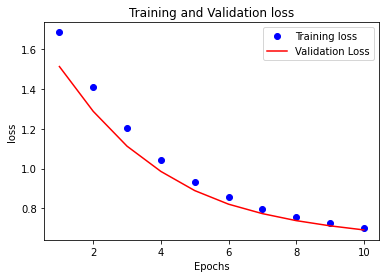

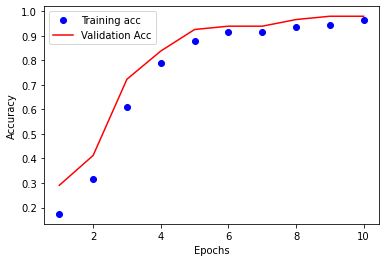

In [57]:

# display the loss curve 
plt.clf()

transaction_dict=train_data.history
loss_values=transaction_dict["loss"]
val_loss_values=transaction_dict["val_loss"]
epochs=range(1,len(transaction_dict["loss"]) + 1)
plt.plot(epochs,loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "r", label="Validation Loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

#validation accuracy 
plt.clf()
acc_values=transaction_dict["accuracy"]
val_acc_values=transaction_dict["val_accuracy"]
epochs=range(1, len(transaction_dict["accuracy"])+1)
plt.plot(epochs, acc_values, 'bo', label="Training acc")
plt.plot(epochs, val_acc_values, "r", label="Validation Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [61]:
# evaluating mmodel on the hold out data 
rawPreds = model.predict(test_data)
print(rawPreds.shape)

Preds=[]
for j in range(rawPreds.shape[0]):
    pos=rawPreds[j].argmax()
    Preds.append(y_test.columns[pos])
    
print(len(Preds))

print(classification_report(Preds, test_labels))

(185, 5)
185
                   precision    recall  f1-score   support

     Train-Inform       0.97      0.93      0.95        40
Train-OfferBooked       0.88      0.93      0.90        15
    Train-Request       0.99      1.00      0.99        66
      general-bye       1.00      1.00      1.00        55
  general-reqmore       1.00      1.00      1.00         9

         accuracy                           0.98       185
        macro avg       0.97      0.97      0.97       185
     weighted avg       0.98      0.98      0.98       185



4. b Could you use this classifier to realize a utterance does not belong to any known type, yet properly classify utterances of known types? How?

one can easily test the model by looking at the probability outputs that a  given utterances will belong to a given class. Using a threshold one could establish a confidence level/ a boundary of acceptability. 



In [64]:
test=model.predict(["can you tell me when the next one is heading to cork is ?"])
print(test)

[[0.2713492  0.10884184 0.3590473  0.12065468 0.140107  ]]


5. Next steps: if you had more time to further develop this proof of concept, 
    what would you propose to do in a next iteration in order to accelerate and 
    improve the analysis of agent utterances?

 The model seems to be classifying with  high degree of accuracy. With a 98% degree accuracy rate, it would make sense to review the data and ensure that what we are being accurate in our predictions from the analysis up to this point. I would recommend drilling into what distinguishes the various classes. Put another way, what attributes have the highest entropy in affecting the classification ?
 